# Topic modeling

In [15]:
import pandas as pd
import joblib
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.exceptions import InconsistentVersionWarning
import warnings
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

import stylia
from stylia import TWO_COLUMNS_WIDTH
from stylia.colors import ContinuousColorMap

base_results_path = "../results/topicmodeling"
results_path = os.path.abspath(os.path.join(base_results_path, "all_outcomes_all_genes"))

print(f"Results path: {results_path}")


Results path: /Users/mduranfrigola/Documents/GitHub/pharmacogx-embeddings/results/topicmodeling/all_outcomes_all_genes


In [16]:
def tokenizer(x):
    return x.split(" ")

topic_data = joblib.load(os.path.join(results_path, "topic_data.joblib"))
processed_topicwizard_data = joblib.load(os.path.join(results_path, "processed_topicwizard_data.joblib"))

topic_names = topic_data["topic_names"]

df = pd.read_csv(os.path.join(results_path, "CompoundHasTopic.csv"))

cmap = ContinuousColorMap()
cmap.fit([i for i in range(len(topic_names))])
topic_colors = cmap.transform([i for i in range(len(topic_names))])

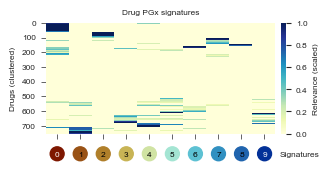

In [32]:
import random
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

fig, axs = stylia.create_figure(2, 1, width=TWO_COLUMNS_WIDTH*0.8*(3/5.2), height=TWO_COLUMNS_WIDTH/4.2, height_ratios=[6,1])

ax = axs.next()

W = processed_topicwizard_data["document_topic_matrix"]

W = sklearn.preprocessing.MinMaxScaler().fit_transform(W)
W[W < 0.1] = 0

ax.set_yticks([i for i in range(len(topic_names))])
ax.set_ylim(len(topic_names), -1)

Z = hierarchy.ward(W)
hierarchy.leaves_list(Z)
clustered_idxs = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, W))

sns.heatmap(W[clustered_idxs], ax=ax, cmap="YlGnBu", cbar_kws={'label': "Relevance (scaled)", "pad": 0.02})
yticks = np.arange(0, 800, 100)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_xticks([i+0.5 for i in range(len(topic_names))])
ax.set_xticklabels("")

stylia.label(ax=ax, title="Drug PGx signatures", ylabel="Drugs (clustered)", xlabel="")

ax = axs.next()

topic_importances = processed_topicwizard_data["topic_importances"]
ax.scatter([i for i in range(len(topic_importances))], [0]*len(topic_importances), s=100, color=topic_colors)
for i in range(len(topic_importances)):
    if i == 0 or i == 9:
        c = "white"
    else:
        c = "black"
    ax.text(i, 0, i, ha="center", va="center", fontsize=6, color=c)
ax.set_axis_off()
ax.set_xlim(-0.5, 11.5)

ax.text(10.5, 0, "Signatures", ha="center", va="center", fontsize=6)

stylia.label(ax=ax, title="", xlabel="", ylabel="", abc="")
stylia.save_figure(os.path.join("assets", "drug_pgx_signatures.png"))

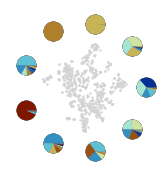

In [36]:
fig, axs = stylia.create_figure(1, 1, width=TWO_COLUMNS_WIDTH*1*(1.2/5.2), height=TWO_COLUMNS_WIDTH/5*1.2)

do_label = False

cids = topic_data["document_names"]

num_compounds = 9

sel_cids = random.sample(cids, num_compounds)
sel_cids_idxs = [cids.index(f) for f in sel_cids]
phis = np.linspace(0, 2*np.pi, num_compounds+1)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def drawPieMarker(xs, ys, ratios, sizes, colors, ax):
    assert sum(ratios) <= 1, 'sum of ratios needs to be < 1'

    markers = []
    previous = 0
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 100)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 100)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color, 'lw':0})

    for marker in markers:
        ax.scatter(xs, ys, **marker, zorder=10000)
        ax.scatter(xs, ys, color="gray", s=200, lw=0)

S = np.array([list(pol2cart(1.5, phi)) for phi in phis])

ax = axs.next()
P = np.array(df[["proj_x", "proj_y"]])
P = MinMaxScaler(feature_range=(-1,1)).fit_transform(P)
ax.scatter(P[:,0], P[:,1], color="lightgray", s=0.5)
ax.scatter(S[:,0], S[:,1])

if do_label:
    for cidx in sel_cids_idxs:
        ax.text(P[cidx, 0], P[cidx, 1], cids[cidx])

W = processed_topicwizard_data["document_topic_matrix"]
for i in range(S.shape[0]-1):
    r = S[i]
    v = W[i,:]
    v = v / np.sum(v)
    v = v*1000
    np.floor(v)
    v = v/1000
    v = v*0.99
    idxs = np.argsort(v)[::-1]
    v = [v[i] for i in idxs]
    c = [topic_colors[i] for i in idxs]
    drawPieMarker([r[0]], [r[1]], v, sizes=[200], colors=c, ax=ax)
    if r[1] >= 0:
        dl = 0.42
    else:
        dl = -0.42
    if do_label:
        ax.text(r[0], r[1] + dl, sel_cids[i], va="center", ha="center")
    
ax.grid(False)
ax.set_axis_off()
ax.set_xlim(-1.8,1.8)
ax.set_ylim(-1.8,1.8)
stylia.label(ax=ax, title="", xlabel="", ylabel="")

if do_label:
    sufix = "_label"
else:
    sufix = ""

stylia.save_figure(os.path.join("assets", f"drug_pgx_signatures_map{sufix}.png"))

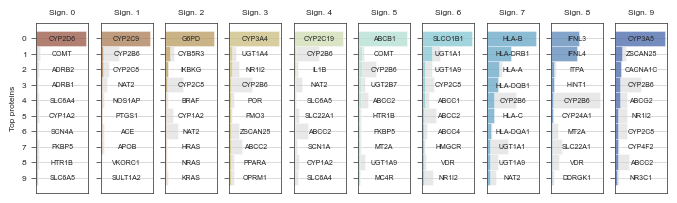

In [39]:
import matplotlib.pyplot as plt

num_proteins = 10

def topic_has_protein_barplot(ax, i):
    topic_name = "Topic {0}".format(i)
    pht = pd.read_csv(os.path.join(results_path, "ProteinHasTopic.csv"))
    pht = pht.sort_values(by=topic_name, ascending=False).head(num_proteins)
    vals = np.array(pht[topic_name])
    gvals = np.array(pht["importance"])
    idxs = [i for i in range(num_proteins)]
    ax.barh(idxs, gvals, lw=0.5, color="lightgray", height=1, alpha=0.5, edgecolor="white")
    ax.barh(idxs, vals, lw=0.5, color=topic_colors[topic_names.index(topic_name)], height=1, alpha=0.5, edgecolor="white")
    xlim = ax.get_xlim()
    ax.set_ylim(len(vals), -1)
    ax.set_title(topic_name.replace("Topic", "Sign."))
    ax.set_yticks([i for i in range(num_proteins)])
    if topic_name == "Topic 0":
        ax.set_ylabel("Top proteins")
    else:
        ax.set_yticklabels("")
        ax.set_ylabel("")
    for i, l in enumerate(pht["gene_name"].tolist()):
        ax.text(xlim[1]*0.5, i, l, ha="center", va="center")
    #ax.set_yticklabels(pht["gene_name"])
    ax.set_xlabel("")
    ax.set_xticks([])
    
    
fig, axs = stylia.create_figure(1, 10, width=TWO_COLUMNS_WIDTH*0.948, height=TWO_COLUMNS_WIDTH*0.28*num_proteins/15)
for i in range(10):
    ax = axs.next()
    topic_has_protein_barplot(ax, i)
plt.tight_layout()

stylia.save_figure("assets/signature_genes.png")